# Classifying Handwritten Digits with MNIST
This notebook aims to use a CNN to classify images of numbers into their numeric labels using the model architecture and data transformations [here](https://nextjournal.com/gkoehler/pytorch-mnist).

In [1]:
# Imports
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
!pip install albumentations --upgrade
import albumentations
import numpy as np
from IPython.display import clear_output

from minitorch import datasets
from minitorch.minitorch import MiniTorch
%load_ext autoreload
%autoreload 2

clear_output()

# Prepare Data

In [2]:
# Download data
torchvision.datasets.MNIST('/content/images/', train=True, download=True)
torchvision.datasets.MNIST('/images/', train=False, download=True)

# Read in data
X_train, y_train = torch.load('/content/images/MNIST/processed/training.pt')
X_test, y_test = torch.load('/content/images/MNIST/processed/test.pt')

# Combine data
X = np.vstack([X_train.numpy(), X_test.numpy()])
y = np.hstack([y_train.numpy(), y_test.numpy()]).astype(str)

clear_output()

In [4]:
X.shape, y.shape

((70000, 28, 28), (70000,))

In [29]:
X[0].shape

(28, 28)

In [7]:
y[0]

'5'

In [31]:
np.random.rand(10,28,28)[0].shape

(28, 28)

In [23]:
np.array(['0']*50 + ['1']*50).shape

(100,)

# Load Data

In [3]:
# Define transformations
tfm = albumentations.Compose([
  albumentations.Normalize(mean=[0.1307], std=[0.3081], p=1.)
], p=1.)
tfms = {
    'train':tfm,
    'validation':tfm,
    'test':tfm,
    'inference':tfm
}

# Instantiate MiniTorch and load data
minitorch = MiniTorch(X, y, 
                      datasets.MatrixDataset,
                      transforms=tfms,
                      val_size=0.10, test_size=0.10,
                      batch_sizes=(64,-1,-1), num_workers=(0,0,0))

Data is split:
Training shape: ((55999, 28, 28), (55999, 10))
Validation shape: ((7000, 28, 28), (7000, 10))
Testing shape: ((7001, 28, 28), (7001, 10))

Data is loaded into DataLoaders.


# Train New Model

In [4]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Load model
minitorch.load_net(net=Net(), weights='equal',
                   chosen_criterion=nn.CrossEntropyLoss, 
                   chosen_optimizer=optim.SGD,
                   chosen_optimizer_params={'lr':0.01, 'momentum':0.5})


Network is loaded.



[1,   150] train_loss: 2.161 | val_loss: 1.571
[1,   300] train_loss: 1.231 | val_loss: 0.564
[1,   450] train_loss: 0.791 | val_loss: 0.405
[1,   600] train_loss: 0.662 | val_loss: 0.333
[1,   750] train_loss: 0.575 | val_loss: 0.275
[2,   150] train_loss: 0.905 | val_loss: 0.230
[2,   300] train_loss: 0.443 | val_loss: 0.207
[2,   450] train_loss: 0.430 | val_loss: 0.193
[2,   600] train_loss: 0.400 | val_loss: 0.174
[2,   750] train_loss: 0.394 | val_loss: 0.162
[3,   150] train_loss: 0.654 | val_loss: 0.155
[3,   300] train_loss: 0.354 | val_loss: 0.151
[3,   450] train_loss: 0.320 | val_loss: 0.140
[3,   600] train_loss: 0.316 | val_loss: 0.136
[3,   750] train_loss: 0.301 | val_loss: 0.133
[4,   150] train_loss: 0.521 | val_loss: 0.124
[4,   300] train_loss: 0.290 | val_loss: 0.123
[4,   450] train_loss: 0.274 | val_loss: 0.114
[4,   600] train_loss: 0.252 | val_loss: 0.118
[4,   750] train_loss: 0.281 | val_loss: 0.113
[5,   150] train_loss: 0.469 | val_loss: 0.108
[5,   300] tr

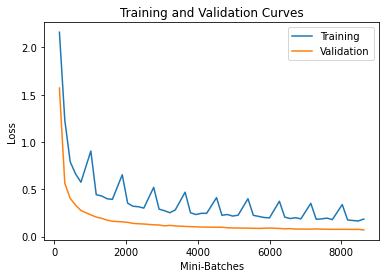

Finished Training


In [6]:
# Train model
minitorch.train(epochs=10, log_mini_batches=150)

# Load Trained Model (optional)

Loaded epoch10_model.pt in eval mode.



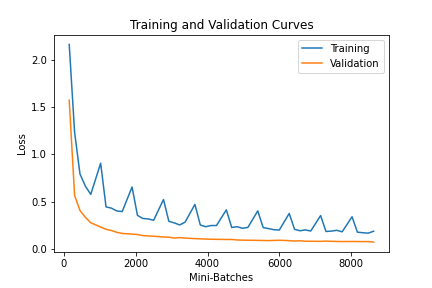

In [7]:
# Load trained model (optional to showcase loading from saved state. Requires model to be defined in current session.)
minitorch = MiniTorch.load_checkpoint(net=Net(), 
                                      checkpoints_path='/content/model_checkpoints/20201228T045603_models/',
                                      model_name='epoch10_model.pt', load_type='eval')

# Evaluate

Evaluating Train set...
100%|██████████| 875/875 [00:12<00:00, 72.07it/s]
Train Accuracy: 98.31%
Train Hit@N: 0.02329

Evaluating Validation set...
100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
Validation Accuracy: 97.90%
Validation Hit@N: 0.03329

Evaluating Test set...
100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
Test Accuracy: 98.09%
Test Hit@N: 0.02585



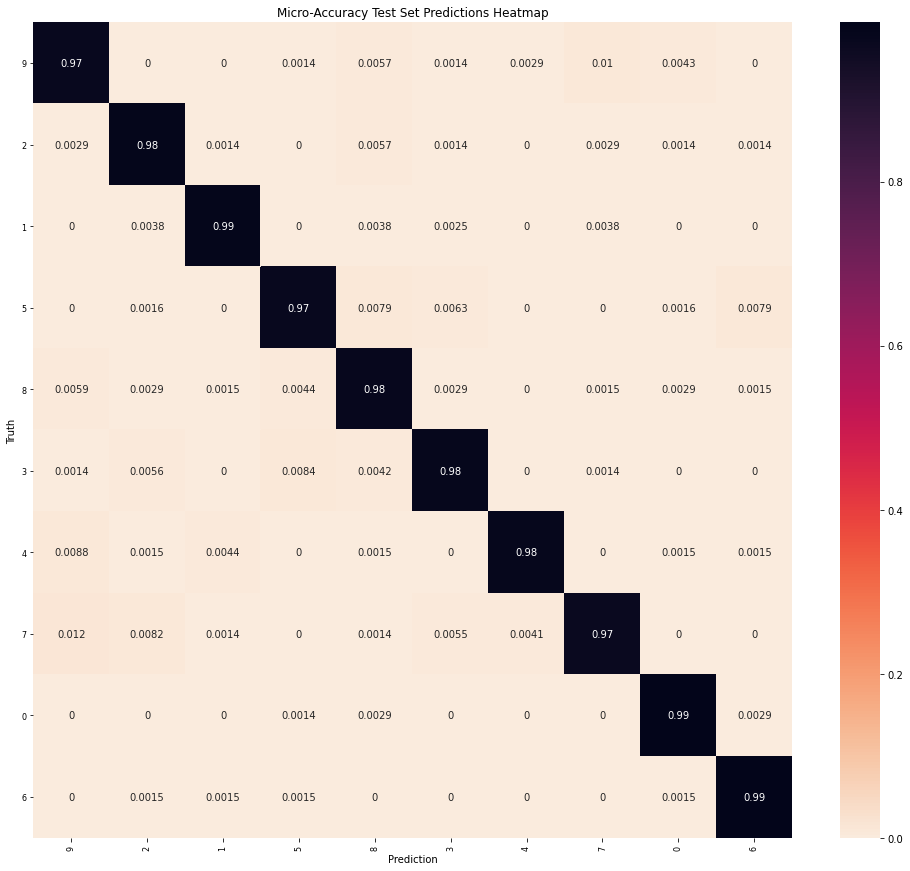

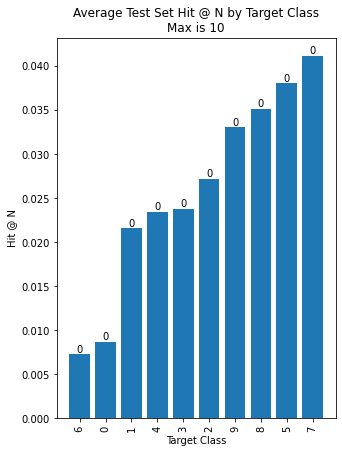

In [8]:
# Evaluate model
minitorch.evaluate(evaluation_metrics=['accuracy', 'hit@n'])